In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 데이터 불러오기

In [3]:
df_광주 = pd.read_csv('data/finish/광주.csv')
df_대구 = pd.read_csv('data/finish/대구.csv')
df_대전 = pd.read_csv('data/finish/대전.csv')
df_부산 = pd.read_csv('data/finish/부산.csv')
df_서울 = pd.read_csv('data/finish/서울.csv')
df_울산 = pd.read_csv('data/finish/울산.csv')
df_인천 = pd.read_csv('data/finish/인천.csv')
df_제주 = pd.read_csv('data/finish/제주.csv')
df_대한민국 = pd.read_csv('data/finish/대한민국.csv')

## class 분류 
- 광주 -> 0
- 대구 -> 1
- 대전 -> 2
- 부산 -> 3
- 서울 -> 4
- 울산 -> 5
- 인천 -> 6
- 제주 -> 7

In [4]:
df_광주['class'] = 0
df_대구['class'] = 1
df_대전['class'] = 2
df_부산['class'] = 3
df_서울['class'] = 4
df_울산['class'] = 5
df_인천['class'] = 6
df_제주['class'] = 7

In [5]:
df0 = df_광주[['preprocessed_data','class']]
df1 = df_대구[['preprocessed_data','class']]
df2 = df_대전[['preprocessed_data','class']]
df3 = df_부산[['preprocessed_data','class']]
df4 = df_서울[['preprocessed_data','class']]
df5 = df_울산[['preprocessed_data','class']]
df6 = df_인천[['preprocessed_data','class']]
df7 = df_제주[['preprocessed_data','class']]

## data concat

In [6]:
dfs = [df0, df1, df2, df3, df4, df5, df6, df7]

In [7]:
df = pd.concat(dfs, ignore_index=True)

In [8]:
df

,preprocessed_data,class
0,민주 운동 연루 기소 유예 처분 재수 검찰 죄 판단 서울서부지검 형사 부부장 검사 ...,0
1,의회 본회의 추경안 제안 설명 제안 설명 강기정 광주시장 제공 판매 금지 연합뉴스 ...,0
2,복합 쇼핑몰 종 오월 정신 헌법 수록 복지 강화 추경 원 광주시의회 힘 지혜 뉴시스...,0
3,내일 일자리 박람회 포스터 제공 뉴스 뉴스 박준 기자 우수 기업 인재 일자리 박람회...,0
4,고용 노동청 주최 우수 중견 중소기업 개사 참여 내일 일자리 박람회 포스터 사진 제...,0
...,...,...
13093,지난해 제주 인구 유출 호남지방통계청 국내 인구 이동 현황 지난하 시도 전입 인구 ...,7
13094,제회 제주포럼오 영훈 지사 필리핀 하원 주한 아랍 사단 면담 제회 포럼 제주국제컨벤...,7
13095,영훈 지사 필리핀 하원 대표단 주한 아랍 사단 면담 경제 관광 에너지 분야 교류 통...,7
13096,첫날 토요일 오늘 구름 많 맑 제주지방기상청 이날 중국 산둥 반도 부근 위치 기압 ...,7


## LSTM Classification

In [9]:
df_trn, df_tst = train_test_split(df, test_size=0.2, stratify=df['class'])

In [10]:
EMBED_DIM = 5000
vectorizer = TfidfVectorizer(max_features=EMBED_DIM)

vectorizer.fit(df_trn['preprocessed_data'])

# train, test data의 preprocessed_desc를 TF-IDF로 변환
x_trn = vectorizer.transform(df_trn['preprocessed_data']).toarray()
x_tst = vectorizer.transform(df_tst['preprocessed_data']).toarray()

In [11]:
y_trn = df_trn['class'].values
y_tst = df_tst['class'].values

In [12]:
#Dataset 정의
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
train_dataset = TextDataset(x_trn, y_trn)
test_dataset = TextDataset(x_tst, y_tst)

In [14]:
# 미니배치 생성기 정의
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                         drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                        drop_last=False)

In [15]:
class LSTMClassifier(nn.Module): #LSTM 모델 정의
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        out, _ = self.lstm(x.unsqueeze(1), (h_0, c_0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [16]:
input_dim = x_trn.shape[1]
hidden_dim = 128
output_dim = len(set(y_trn))

In [17]:
model = LSTMClassifier(input_dim, hidden_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

LSTMClassifier(
  (lstm): LSTM(5000, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [18]:
# 손실함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# 학습
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

Epoch 1/10, Loss: 1.712668693211465
Epoch 2/10, Loss: 0.5990522116969484
Epoch 3/10, Loss: 0.274798990366838
Epoch 4/10, Loss: 0.1695312466073656
Epoch 5/10, Loss: 0.1142652077537702
Epoch 6/10, Loss: 0.08098093730992771
Epoch 7/10, Loss: 0.06430235391038411
Epoch 8/10, Loss: 0.05309920145244272
Epoch 9/10, Loss: 0.04659255064058399
Epoch 10/10, Loss: 0.040427754701126584


In [20]:
# 평가
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {correct / total}')

Test Accuracy: 0.9148854961832061


### 대한민국 데이터를 이 모델에 넣어보자
- 서울-제주 8개의 지역으로 학습시킨 모델은 대한민국을 어디로 분류할까

In [21]:
korea = vectorizer.transform(df_대한민국['preprocessed_data']).toarray()

In [22]:
class TextDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

In [23]:
korea_dataset = TextDataset(korea)
korea_loader = DataLoader(korea_dataset, batch_size=32, shuffle=False, drop_last=False)

In [24]:
# 모델 평가
model.eval()
predictions = []
with torch.no_grad():
    for inputs in korea_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        predictions.extend(predicted.cpu().numpy())

### 예측값 시각화

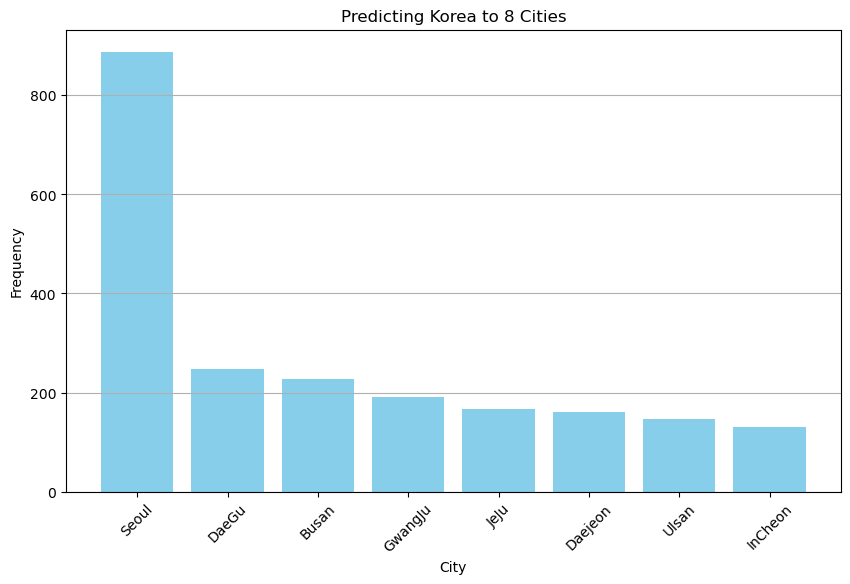

In [25]:
mapping = {0: 'GwangJu', 1: 'DaeGu', 2: 'Daejeon', 3: 'Busan', 4: 'Seoul', 5: 'Ulsan', 6: 'InCheon', 7: 'JeJu'}

#class를 도시 이름으로 바꾸기
cities = [mapping[num] for num in predictions]

df = pd.DataFrame(cities, columns=['city'])

frequency = df['city'].value_counts().sort_values(ascending=False)

frequency_df = pd.DataFrame({'city': frequency.index, 'count': frequency.values})

plt.figure(figsize=(10, 6))
plt.bar(frequency_df['city'], frequency_df['count'], color='skyblue')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.title('Predicting Korea to 8 Cities')
plt.xticks(rotation=45)
plt.grid(axis='y')

# 그래프 표시
plt.show()